In [ ]:
import polars as pl
import os
from pathlib import Path

In [ ]:
FOLDER = "C:\\Users\\johan/OneDrive//Documents//Python//Python//SilverStone"

In [ ]:
path = Path("\\TrackLanes.parquet")
df = pl.read_parquet(path)

In [ ]:
ldf = df.lazy()
aldf = ldf.with_columns([
    (pl.col("x_m").shift(-1) - pl.col("x_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("x_dir"),
    (pl.col("y_m").shift(-1) - pl.col("y_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("y_dir"),
    (pl.col("w_tr_left_m") + pl.col("w_tr_right_m")).alias("width")
]).with_columns([
    (pl.col("x_dir")*pl.col("x_dir") + pl.col("y_dir")*pl.col("y_dir")).sqrt().alias("norm_dir")
]).with_columns([
    (pl.col("x_dir")/pl.col("norm_dir")).alias("x_udir"),
    (pl.col("y_dir")/pl.col("norm_dir")).alias("y_udir")
])

N_LANES = 11
lane_factors = [-0.5 + i / (N_LANES - 1) for i in range(N_LANES)]
print(lane_factors)
aldf = aldf.with_columns(
        [(pl.col("x_m") + pl.lit(f) * pl.col("width") * pl.col("y_udir")).alias(f"x_lane{i}") for i, f in enumerate(lane_factors)] +
        [(pl.col("y_m") - pl.lit(f) * pl.col("width") * pl.col("x_udir")).alias(f"y_lane{i}") for i, f in enumerate(lane_factors)]
    )

lanesdfd = aldf.collect()
lanesdfd.describe()
lanesdfd

In [ ]:
df = aldf.collect()
columns = dict([(i,name) for name,i in enumerate(df.columns)])
print(columns)
arr = df.to_numpy()
arr.shape

In [ ]:
df = tldf.collect()
columns = dict([(i,name) for name,i in enumerate(df.columns)])
arr = tldf.collect().to_numpy()
arr

T, S, A = costs.shape
V = np.zeros((T, S))
policy = np.zeros((T, S), dtype=int)

# terminal time
V[-1] = np.min(costs[-1], axis=1)        # min over actions
policy[-1] = np.argmin(costs[-1], axis=1)

# backward induction
for t in range(T - 2, -1, -1):
    # q[t, s, a] = C[t, s, a] + gamma * V[t+1, s]
    # We need to broadcast V[t+1] to match actions axis
    cont = gamma * V[t + 1][:, None]     # shape (S, 1)
    q = costs[t] + cont                  # shape (S, A)

    policy[t] = np.argmin(q, axis=1)
    V[t] = np.min(q, axis=1)

return V, policy

In [ ]:
import numpy as np

T, S = arr.shape
print(T,S)
A = N_LANES*N_SPEEDS
print(A)

def cost_for_action(X, a):
    print(X.shape)
    if a == 0:
        return X
    elif a == 1:
        return 2 * X + 1
    elif a == 2:
        return X**2
    else:
        raise ValueError("Unknown action")

C = np.empty((T, S, A))
action_d = {}
for i in range(N_LANES): 
    for j in range(N_SPEEDS): 
        a = i*N_LANES + j
        action_d["{i}_{j}"] = i*N_LANES + j
        C[..., a] = cost_for_action(arr, a)
        
# for a in range(A):
#     C[..., a] = cost_for_action(arr, a)
arr

In [18]:
#how much can we add in terms of transition data
N_SPEEDS = 21
tldf = aldf
print(tldf.collect().estimated_size("mb"))
tldf = tldf.with_columns(
        [(pl.col("x_m")).alias(f"lane_{i}_speed_{j}") for i,f in enumerate(lane_factors) for j in range(N_SPEEDS)]
)
print(tldf.collect().estimated_size("mb"))


0.2914085388183594
2.367504119873047


In [ ]:
df = tldf.collect()
columns = dict([(i,name) for name,i in enumerate(df.columns)])
arr = tldf.collect().to_numpy().transpose()
arr
N = len(arr[0])
def exp(i,j):
    neighbours = [
        (j0, j1, pl.col(f"distance_{i0}_{j0}") +  pl.col(f"min_cost_l{i0}s{j0}").shift(-1))
        for j0 in range(max(0, i0 - 2), min(N_LANES, i0 + 3))
        for j1 in range(max(0, i1 - 2), min(N_SPEEDS, i1 + 3))
    ]

    dist_exprs = [d for (_, _, d) in neighbours]
    min_dist = pl.min_horizontal(dist_exprs)

    # Build both j0 and j1 CASE expressions in the same loop
    
    j0_case = None
    j1_case = None
    for j0, j1, dist in neighbours:
        cond = (dist == min_dist)

        if j0_case is None:
            j0_case = pl.when(cond).then(j0)
        else:
            j0_case = j0_case.when(cond).then(j0)

        if j1_case is None:
            j1_case = pl.when(cond).then(j1)
        else:
            j1_case = j1_case.when(cond).then(j1)
    
    # Finalize both with .otherwise(None)
    j0_case = j0_case.otherwise(None)
    j1_case = j1_case.otherwise(None)
            
    return [
        min_dist.alias(f"min_cost_l{i0}s{i1}"),
        j0_case.alias(f"min_cost_l{i0}s{i1}_j0"),
        j1_case.alias(f"min_cost_l{i0}s{i1}_j
                      

    return 0
d = {}
for i in range(N_LANES): 
    for j in range(N_SPEEDS): 
        l = [exp(i) for i in range(N)]
        # "min_cost_l{i0}s{i1}"
        # "min_cost_l{i0}s{i1}_j0"
        # "min_cost_l{i0}s{i1}_j1"
        #tldf2 = tldf2.with_columns( cost_expr(i,j) )
        d["min_cost_l{i0}s{i1}"] = l
d


In [ ]:

def cost_expr(i0: int, i1: int) -> list[pl.Expr]:
    # neighbourhood list
    neighbours = [
        (j0, j1, pl.col(f"distance_{i0}_{j0}") +  pl.col(f"min_cost_l{i0}s{j0}").shift(-1))
        for j0 in range(max(0, i0 - 2), min(N_LANES, i0 + 3))
        for j1 in range(max(0, i1 - 2), min(N_SPEEDS, i1 + 3))
    ]

    dist_exprs = [d for (_, _, d) in neighbours]
    min_dist = pl.min_horizontal(dist_exprs)

    # Build both j0 and j1 CASE expressions in the same loop
    
    j0_case = None
    j1_case = None
    for j0, j1, dist in neighbours:
        cond = (dist == min_dist)

        if j0_case is None:
            j0_case = pl.when(cond).then(j0)
        else:
            j0_case = j0_case.when(cond).then(j0)

        if j1_case is None:
            j1_case = pl.when(cond).then(j1)
        else:
            j1_case = j1_case.when(cond).then(j1)
    
    # Finalize both with .otherwise(None)
    j0_case = j0_case.otherwise(None)
    j1_case = j1_case.otherwise(None)
            
    return [
        min_dist.alias(f"min_cost_l{i0}s{i1}"),
        j0_case.alias(f"min_cost_l{i0}s{i1}_j0"),
        j1_case.alias(f"min_cost_l{i0}s{i1}_j1"),
    ]
def build_columns():
    columns = []
    for i in range(1): 
        for j in range(1):
            columns.append(cost_expr(i,j))
    return columns

def build_columns(i,j):
    c = cost_expr(i,j)
    #c.append(cost_expr(0,0))
    return c

tldf2 = tldf
for i in range(1): 
    for j in range(1): 
        tldf2 = tldf2.with_columns( cost_expr(i,j) )

tldf2.collect()

In [ ]:
tldf = aldf
print(tldf.collect().estimated_size("mb"))
tldf = tldf.with_columns(
        [((pl.col("x_lane"+str(i1)).shift(-1)-pl.col("x_lane"+str(i0))).pow(2) + 
          (pl.col("y_lane"+str(i1)).shift(-1)-pl.col("y_lane"+str(i0))).pow(2)).sqrt().fill_null(strategy="forward").alias(f"distance_{i0}_{i1}")
         for i0 in range(N_LANES) for i1 in range(N_LANES)]
        )
tldf.collect()

In [5]:
#Create and add the lanes
ldf = df.lazy()
aldf = ldf.with_columns([
    (pl.col("x_m").shift(-1) - pl.col("x_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("x_dir"),
    (pl.col("y_m").shift(-1) - pl.col("y_m").shift(1)).fill_null(strategy="forward").fill_null(strategy="backward").alias("y_dir"),
    (pl.col("w_tr_left_m") + pl.col("w_tr_right_m")).alias("width")
]).with_columns([
    (pl.col("x_dir")*pl.col("x_dir") + pl.col("y_dir")*pl.col("y_dir")).sqrt().alias("norm_dir")
]).with_columns([
    (pl.col("x_dir")/pl.col("norm_dir")).alias("x_udir"),
    (pl.col("y_dir")/pl.col("norm_dir")).alias("y_udir")
])

N_LANES = 11
lane_factors = [-0.5 + i / (N_LANES - 1) for i in range(N_LANES)]
print(lane_factors)
aldf = aldf.with_columns(
        [(pl.col("x_m") + pl.lit(f) * pl.col("width") * pl.col("y_udir")).alias(f"x_lane{i}") for i, f in enumerate(lane_factors)] +
        [(pl.col("y_m") - pl.lit(f) * pl.col("width") * pl.col("x_udir")).alias(f"y_lane{i}") for i, f in enumerate(lane_factors)]
    )

lanesdfd = aldf.collect()
lanesdfd.describe()
lanesdfd

[-0.5, -0.4, -0.3, -0.2, -0.09999999999999998, 0.0, 0.09999999999999998, 0.19999999999999996, 0.30000000000000004, 0.4, 0.5]


x_m,y_m,w_tr_right_m,w_tr_left_m,x_dir,y_dir,width,norm_dir,x_udir,y_udir,x_lane0,x_lane1,x_lane2,x_lane3,x_lane4,x_lane5,x_lane6,x_lane7,x_lane8,x_lane9,x_lane10,y_lane0,y_lane1,y_lane2,y_lane3,y_lane4,y_lane5,y_lane6,y_lane7,y_lane8,y_lane9,y_lane10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.439354,-0.495322,6.556,6.536,5.862596,8.10221,13.092,10.000792,0.586213,0.810157,-1.863933,-0.803275,0.257382,1.318039,2.378697,3.439354,4.500011,5.560669,6.621326,7.681983,8.742641,3.342029,2.574559,1.807089,1.039619,0.272148,-0.495322,-1.262792,-2.030263,-2.797733,-3.565203,-4.332673
6.370784,3.555763,6.558,6.537,5.862596,8.10221,13.095,10.000792,0.586213,0.810157,1.066282,2.127182,3.188083,4.248983,5.309884,6.370784,7.431684,8.492585,9.553485,10.614386,11.675286,7.393994,6.626348,5.858701,5.091055,4.323409,3.555763,2.788117,2.020471,1.252825,0.485178,-0.282468
9.30195,7.606888,6.56,6.538,5.862087,8.102292,13.098,10.00056,0.586176,0.810184,3.996056,5.057235,6.118414,7.179592,8.240771,9.30195,10.363129,11.424308,12.485486,13.546665,14.607844,11.445754,10.677981,9.910207,9.142434,8.374661,7.606888,6.839115,6.071342,5.303569,4.535795,3.768022
12.232871,11.658055,6.562,6.539,5.861618,8.10238,13.101,10.000356,0.586141,0.810209,6.925596,7.987051,9.048506,10.109961,11.171416,12.232871,13.294326,14.355781,15.417236,16.478691,17.540146,15.497571,14.729668,13.961765,13.193861,12.425958,11.658055,10.890152,10.122249,9.354345,8.586442,7.818539
15.163568,15.709268,6.564,6.54,5.861189,8.102473,13.104,10.00018,0.586108,0.810233,9.854923,10.916652,11.978381,13.04011,14.101839,15.163568,16.225297,17.287026,18.348755,19.410484,20.472213,19.54945,18.781413,18.013377,17.245341,16.477304,15.709268,14.941232,14.173195,13.405159,12.637123,11.869086
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-11.222438,-20.750233,6.535,6.559,5.866447,8.101822,13.094,10.002736,0.586484,0.809961,-16.52525,-15.464688,-14.404125,-13.343563,-12.283,-11.222438,-10.161876,-9.101313,-8.040751,-6.980188,-5.919626,-16.910521,-17.678463,-18.446406,-19.214348,-19.982291,-20.750233,-21.518175,-22.286118,-23.05406,-23.822003,-24.589945
-8.289395,-16.699311,6.54,6.553,5.865724,8.101872,13.093,10.002352,0.586434,0.809997,-13.592038,-12.53151,-11.470981,-10.410452,-9.349924,-8.289395,-7.228866,-6.168338,-5.107809,-4.04728,-2.986752,-12.860218,-13.628036,-14.395855,-15.163674,-15.931492,-16.699311,-17.46713,-18.234948,-19.002767,-19.770586,-20.538404
-5.356714,-12.648361,6.544,6.548,5.865019,8.10193,13.092,10.001986,0.586385,0.810032,-10.659184,-9.59869,-8.538196,-7.477702,-6.417208,-5.356714,-4.29622,-3.235726,-2.175232,-1.114738,-0.054244,-8.809882,-9.577578,-10.345273,-11.112969,-11.880665,-12.648361,-13.416057,-14.183753,-14.951449,-15.719144,-16.48684


In [6]:
import plotly.graph_objects as go
fig = go.Figure()

for i in range(N_LANES):
    fig.add_trace(go.Scatter(
        x = lanesdfd["x_lane" + str(i)].to_numpy(),
        y = lanesdfd["y_lane" + str(i)].to_numpy(),
        mode = "markers",
        marker  = dict(size=3),
        name = "lane " + str(i)
    ))

fig.update_layout(
    width=1200,
    height=1000,
    title="Track Lanes",
    xaxis=dict(scaleanchor="y", scaleratio=1),
)

fig.show()

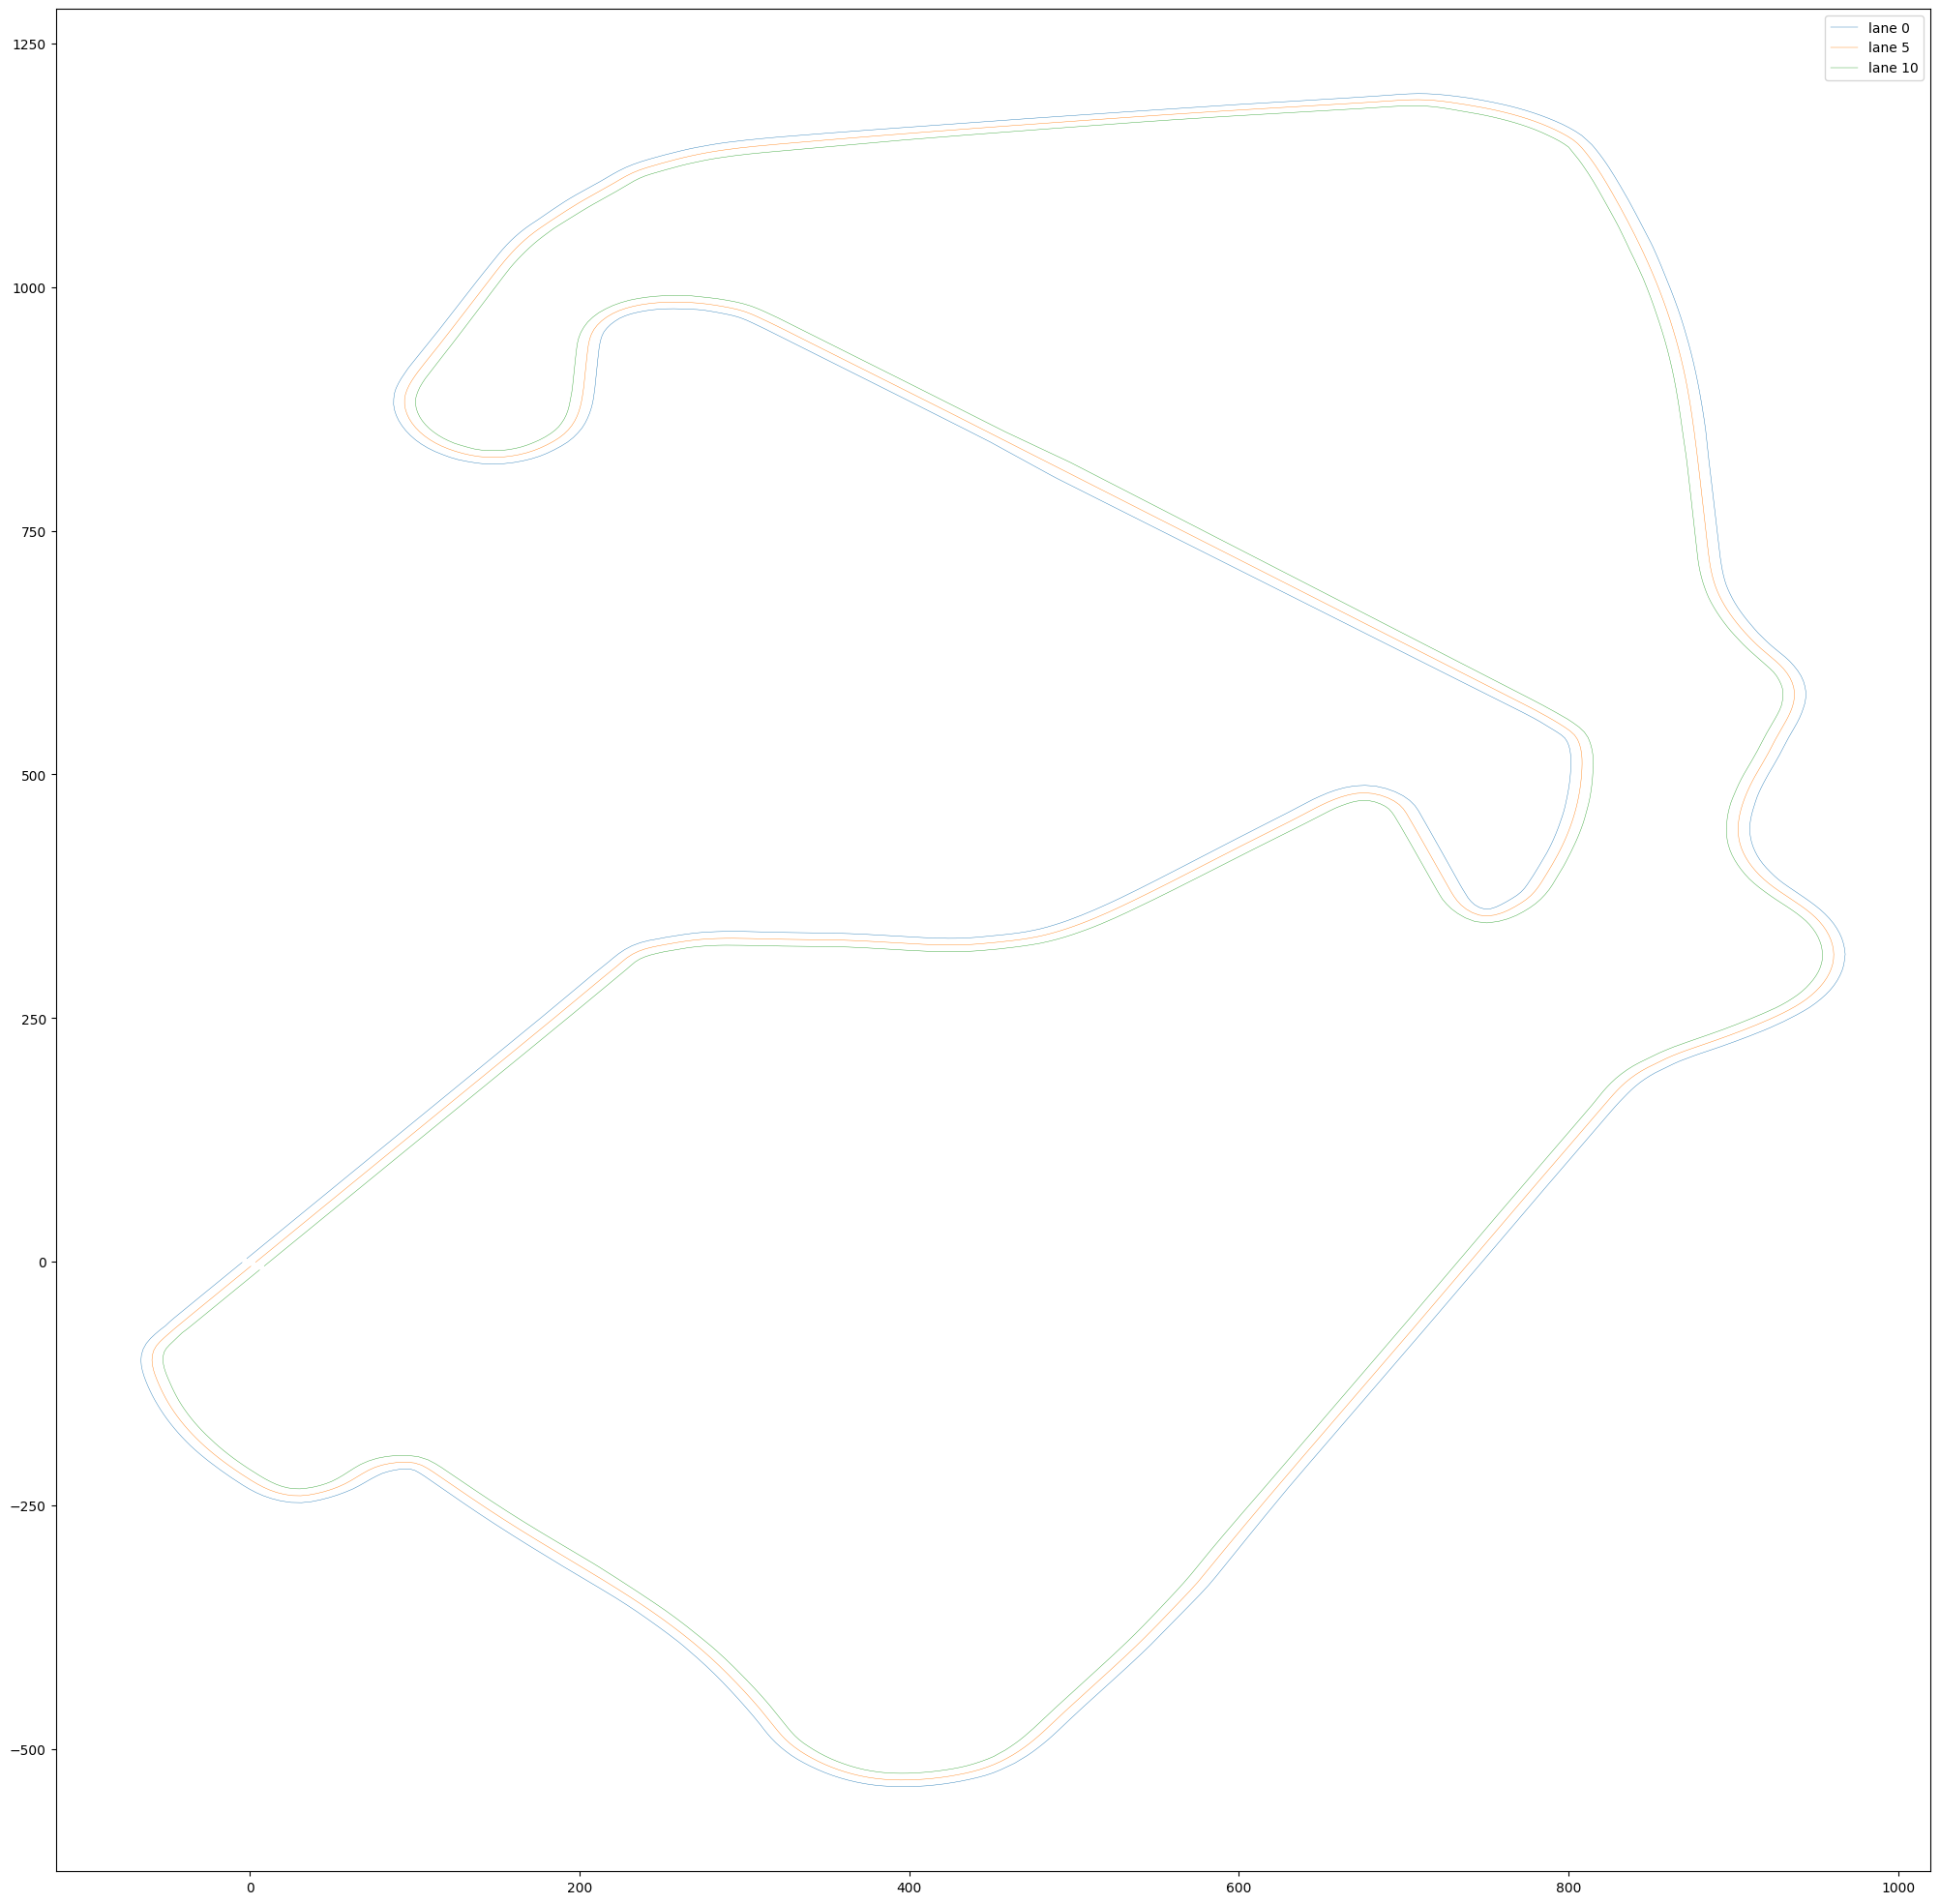

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))

plt.plot(lanesdfd["x_lane0"].to_numpy(),
         lanesdfd["y_lane0"].to_numpy(),
         linewidth=0.3,
         label="lane 0")

plt.plot(lanesdfd["x_lane5"].to_numpy(),
         lanesdfd["y_lane5"].to_numpy(),
         linewidth=0.3,
         label="lane 5")

plt.plot(lanesdfd["x_lane10"].to_numpy(),
         lanesdfd["y_lane10"].to_numpy(),
         linewidth=0.3,
         label="lane 10")

plt.legend()
plt.show()

In [8]:
path = Path(folder_path + r"\\TrackLanes.parquet")
df.write_parquet(path)

In [142]:
#how much can we add in terms of transition data
N_SPEEDS = 21
tldf = aldf
print(tldf.collect().estimated_size("mb"))
tldf = tldf.with_columns(
        [(pl.col("x_m")).alias(f"lane_{i}_speed_{j}") for i,f in enumerate(lane_factors) for j in range(N_SPEEDS)]
)
print(tldf.collect().estimated_size("mb"))


0.2914085388183594
2.367504119873047


In [151]:
tldf = aldf
print(tldf.collect().estimated_size("mb"))
tldf = tldf.with_columns(
        [((pl.col("x_lane"+str(i1)).shift(-1)-pl.col("x_lane"+str(i0))).pow(2) + 
          (pl.col("y_lane"+str(i1)).shift(-1)-pl.col("y_lane"+str(i0))).pow(2)).sqrt().fill_null(strategy="forward").alias(f"distance_{i0}_{i1}")
         for i0 in range(N_LANES) for i1 in range(N_LANES)]
        )
tldf.collect()

0.2914085388183594


x_m,y_m,w_tr_right_m,w_tr_left_m,x_dir,y_dir,width,norm_dir,x_udir,y_udir,x_lane0,x_lane1,x_lane2,x_lane3,x_lane4,x_lane5,x_lane6,x_lane7,x_lane8,x_lane9,x_lane10,y_lane0,y_lane1,y_lane2,y_lane3,y_lane4,y_lane5,y_lane6,y_lane7,y_lane8,y_lane9,y_lane10,distance_0_0,distance_0_1,distance_0_2,distance_0_3,distance_0_4,…,distance_7_7,distance_7_8,distance_7_9,distance_7_10,distance_8_0,distance_8_1,distance_8_2,distance_8_3,distance_8_4,distance_8_5,distance_8_6,distance_8_7,distance_8_8,distance_8_9,distance_8_10,distance_9_0,distance_9_1,distance_9_2,distance_9_3,distance_9_4,distance_9_5,distance_9_6,distance_9_7,distance_9_8,distance_9_9,distance_9_10,distance_10_0,distance_10_1,distance_10_2,distance_10_3,distance_10_4,distance_10_5,distance_10_6,distance_10_7,distance_10_8,distance_10_9,distance_10_10
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3.439354,-0.495322,6.556,6.536,5.862596,8.10221,13.092,10.000792,0.586213,0.810157,-1.863933,-0.803275,0.257382,1.318039,2.378697,3.439354,4.500011,5.560669,6.621326,7.681983,8.742641,3.342029,2.574559,1.807089,1.039619,0.272148,-0.495322,-1.262792,-2.030263,-2.797733,-3.565203,-4.332673,5.000457,5.168728,5.644156,6.35821,7.240632,…,5.000457,5.16926,5.64513,6.359507,11.607317,10.440815,9.312412,8.237778,7.240894,6.358434,5.644324,5.168819,5.000457,5.169336,5.64527,12.80123,11.607046,10.440552,9.312159,8.23754,7.240677,6.358249,5.644185,5.168744,5.000457,5.169412,14.015749,12.800954,11.606775,10.440288,9.311906,8.237301,7.24046,6.358063,5.644046,5.168668,5.000457
6.370784,3.555763,6.558,6.537,5.862596,8.10221,13.095,10.000792,0.586213,0.810157,1.066282,2.127182,3.188083,4.248983,5.309884,6.370784,7.431684,8.492585,9.553485,10.614386,11.675286,7.393994,6.626348,5.858701,5.091055,4.323409,3.555763,2.788117,2.020471,1.252825,0.485178,-0.282468,5.000034,5.168392,5.644056,6.358428,7.241202,…,5.000455,5.169332,5.645404,6.360057,11.609514,10.442693,9.313968,8.239011,7.241807,6.35904,5.644658,5.168954,5.000516,5.169466,5.645597,12.803769,11.60927,10.442458,9.313747,8.23881,7.241632,6.358902,5.644572,5.168936,5.000576,5.169601,14.018622,12.803516,11.609025,10.442224,9.313526,8.238608,7.241457,6.358764,5.644486,5.168919,5.000636
9.30195,7.606888,6.56,6.538,5.862087,8.102292,13.098,10.00056,0.586176,0.810184,3.996056,5.057235,6.118414,7.179592,8.240771,9.30195,10.363129,11.424308,12.485486,13.546665,14.607844,11.445754,10.677981,9.910207,9.142434,8.374661,7.606888,6.839115,6.071342,5.303569,4.535795,3.768022,4.999943,5.168378,5.64425,6.358908,7.242002,…,5.000338,5.169293,5.645575,6.360517,11.611635,10.444485,9.315428,8.240136,7.242597,6.359506,5.644833,5.168915,5.000395,5.169424,5.645765,12.806213,11.611389,10.444249,9.315205,8.239932,7.242419,6.359365,5.644743,5.168893,5.000451,5.169555,14.021385,12.805958,11.611142,10.444012,9.314982,8.239728,7.242241,6.359224,5.644654,5.168872,5.000508
12.232871,11.658055,6.562,6.539,5.861618,8.10238,13.101,10.000356,0.586141,0.810209,6.925596,7.987051,9.048506,10.109961,11.171416,12.232871,13.294326,14.355781,15.417236,16.478691,17.540146,15.497571,14.729668,13.961765,13.193861,12.425958,11.658055,10.890152,10.122249,9.354345,8.586442,7.818539,4.999868,5.16838,5.644459,6.359401,7.242813,…,5.000237,5.169269,5.64576,6.360989,11.613762,10.446285,9.316896,8.24127,7.243398,6.359983,5.645021,5.16889,5.000289,5.169396,5.645946,12.808662,11.613514,10.446047,9.316671,8.241064,7.243217,6.359839,5.644928,5.168865,5.000342,5.169523,14.024155,12.808407,11.613266,10.445808,9.316446,8.240857,7.243037,6.359695,5.644836,5.16884,5.000395
15.163568,15.709268,6.564,6.54,5.861189,8.102473,13.104,10.00018,0.586108,0.810233,9.854923,10.916652,11.978381,13.04011,14.101839,15.163568,16.225297,17.287026,18.348755,19.410484,20.472213,19

In [159]:

def cost_expr(i0: int, i1: int) -> list[pl.Expr]:
    # neighbourhood list
    neighbours = [
        (j0, j1, pl.col(f"distance_{i0}_{j0}") +  pl.col(f"min_cost_l{i0}s{j0}").shift(-1))
        for j0 in range(max(0, i0 - 2), min(N_LANES, i0 + 3))
        for j1 in range(max(0, i1 - 2), min(N_SPEEDS, i1 + 3))
    ]

    dist_exprs = [d for (_, _, d) in neighbours]
    min_dist = pl.min_horizontal(dist_exprs)

    # Build both j0 and j1 CASE expressions in the same loop
    
    j0_case = None
    j1_case = None
    for j0, j1, dist in neighbours:
        cond = (dist == min_dist)

        if j0_case is None:
            j0_case = pl.when(cond).then(j0)
        else:
            j0_case = j0_case.when(cond).then(j0)

        if j1_case is None:
            j1_case = pl.when(cond).then(j1)
        else:
            j1_case = j1_case.when(cond).then(j1)
    
    # Finalize both with .otherwise(None)
    j0_case = j0_case.otherwise(None)
    j1_case = j1_case.otherwise(None)
            
    return [
        min_dist.alias(f"min_cost_l{i0}s{i1}"),
        j0_case.alias(f"min_cost_l{i0}s{i1}_j0"),
        j1_case.alias(f"min_cost_l{i0}s{i1}_j1"),
    ]
def build_columns():
    columns = []
    for i in range(1): 
        for j in range(1):
            columns.append(cost_expr(i,j))
    return columns

def build_columns(i,j):
    c = cost_expr(i,j)
    #c.append(cost_expr(0,0))
    return c

tldf2 = tldf
for i in range(1): 
    for j in range(1): 
        tldf2 = tldf2.with_columns( cost_expr(i,j) )

tldf2.collect()

ColumnNotFoundError: min_cost_l0s0

In [ ]:
df = tldf.collect()
columns = dict([(i,name) for name,i in enumerate(df.columns)])
arr = tldf.collect().to_numpy().transpose()
arr
N = len(arr[0])
def exp(i,j):
    neighbours = [
        (j0, j1, pl.col(f"distance_{i0}_{j0}") +  pl.col(f"min_cost_l{i0}s{j0}").shift(-1))
        for j0 in range(max(0, i0 - 2), min(N_LANES, i0 + 3))
        for j1 in range(max(0, i1 - 2), min(N_SPEEDS, i1 + 3))
    ]

    dist_exprs = [d for (_, _, d) in neighbours]
    min_dist = pl.min_horizontal(dist_exprs)

    # Build both j0 and j1 CASE expressions in the same loop
    
    j0_case = None
    j1_case = None
    for j0, j1, dist in neighbours:
        cond = (dist == min_dist)

        if j0_case is None:
            j0_case = pl.when(cond).then(j0)
        else:
            j0_case = j0_case.when(cond).then(j0)

        if j1_case is None:
            j1_case = pl.when(cond).then(j1)
        else:
            j1_case = j1_case.when(cond).then(j1)
    
    # Finalize both with .otherwise(None)
    j0_case = j0_case.otherwise(None)
    j1_case = j1_case.otherwise(None)
            
    return [
        min_dist.alias(f"min_cost_l{i0}s{i1}"),
        j0_case.alias(f"min_cost_l{i0}s{i1}_j0"),
        j1_case.alias(f"min_cost_l{i0}s{i1}_j
                      

    return 0
d = {}
for i in range(N_LANES): 
    for j in range(N_SPEEDS): 
        l = [exp(i) for i in range(N)]
        # "min_cost_l{i0}s{i1}"
        # "min_cost_l{i0}s{i1}_j0"
        # "min_cost_l{i0}s{i1}_j1"
        #tldf2 = tldf2.with_columns( cost_expr(i,j) )
        d["min_cost_l{i0}s{i1}"] = l
d


{'min_cost_l{i0}s{i1}': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [202]:
df = aldf.collect()
columns = dict([(i,name) for name,i in enumerate(df.columns)])
print(columns)
arr = df.to_numpy()
arr.shape

{'x_m': 0, 'y_m': 1, 'w_tr_right_m': 2, 'w_tr_left_m': 3, 'x_dir': 4, 'y_dir': 5, 'width': 6, 'norm_dir': 7, 'x_udir': 8, 'y_udir': 9, 'x_lane0': 10, 'x_lane1': 11, 'x_lane2': 12, 'x_lane3': 13, 'x_lane4': 14, 'x_lane5': 15, 'x_lane6': 16, 'x_lane7': 17, 'x_lane8': 18, 'x_lane9': 19, 'x_lane10': 20, 'y_lane0': 21, 'y_lane1': 22, 'y_lane2': 23, 'y_lane3': 24, 'y_lane4': 25, 'y_lane5': 26, 'y_lane6': 27, 'y_lane7': 28, 'y_lane8': 29, 'y_lane9': 30, 'y_lane10': 31}


(1178, 32)

In [208]:
import numpy as np

T, S = arr.shape
print(T,S)
A = N_LANES*N_SPEEDS
print(A)

def cost_for_action(X, a):
    print(X.shape)
    if a == 0:
        return X
    elif a == 1:
        return 2 * X + 1
    elif a == 2:
        return X**2
    else:
        raise ValueError("Unknown action")

C = np.empty((T, S, A))
action_d = {}
for i in range(N_LANES): 
    for j in range(N_SPEEDS): 
        a = i*N_LANES + j
        action_d["{i}_{j}"] = i*N_LANES + j
        C[..., a] = cost_for_action(arr, a)
        
# for a in range(A):
#     C[..., a] = cost_for_action(arr, a)
arr

1178 32
231
(1178, 32)
(1178, 32)
(1178, 32)
(1178, 32)


ValueError: Unknown action

In [ ]:
df = tldf.collect()
columns = dict([(i,name) for name,i in enumerate(df.columns)])
arr = tldf.collect().to_numpy()
arr

T, S, A = costs.shape
V = np.zeros((T, S))
policy = np.zeros((T, S), dtype=int)

# terminal time
V[-1] = np.min(costs[-1], axis=1)        # min over actions
policy[-1] = np.argmin(costs[-1], axis=1)

# backward induction
for t in range(T - 2, -1, -1):
    # q[t, s, a] = C[t, s, a] + gamma * V[t+1, s]
    # We need to broadcast V[t+1] to match actions axis
    cont = gamma * V[t + 1][:, None]     # shape (S, 1)
    q = costs[t] + cont                  # shape (S, A)

    policy[t] = np.argmin(q, axis=1)
    V[t] = np.min(q, axis=1)

return V, policy

In [ ]:

def cost_expr(i0: int, i1: int) -> pl.Expr:
    # start with some base
    expr = pl.lit(0)

    expr = expr + pl.min([pl("distance_{i0}_{i1}"), pl("distance_{i0}_{i1}")])
    # add pieces step by step
    expr = expr + pl.lit(10 * i + 1)

    # example: add something depending on speed bin j
    expr = expr + pl.when(pl.col("speed_bin") == j).then(5).otherwise(0)

    # another example: use lane_factors[i]
    # expr = expr + pl.lit(lane_factors[i]) * pl.col("some_column")

    return expr

tldf.with_columns(
        [cost_expr(i,j).alias(f"cost_lane_{i}_speed_{j}")
          for i,f in enumerate(lane_factors) for j in range(20)]
)

In [ ]:
#Adding the transition data
#Create and add the lanes


0.2914085388183594

aldf.collect().estimate_size()

In [ ]:

pl.read_excel("C:\Users\johan\OneDrive\Documents\Python\Python\SilverStone\TrackData.csv")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1913170299.py, line 1)

In [15]:
from pathlib import Path

my_file = Path(path)
my_file.is_file()

NameError: name 'path' is not defined